In [35]:
import backtrader as bt
import yfinance as yf
import pandas as pd
from strategy.ma_cross import MaCrossStrategy

C:\Users\Gary\AppData\Local\Temp\ipykernel_17004\836634031.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2021-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed


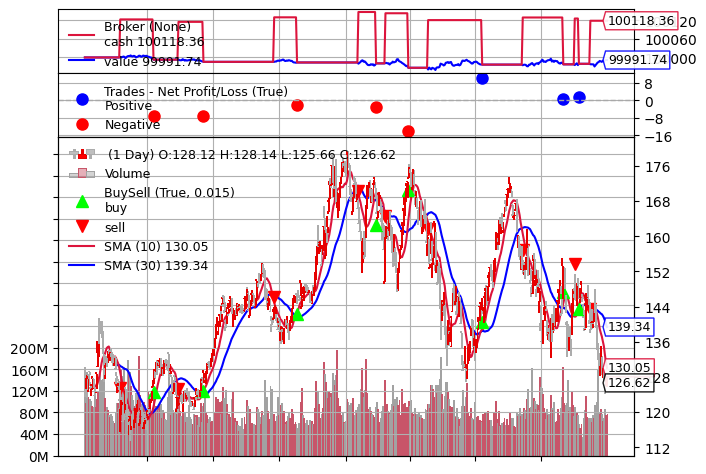

[[<Figure size 640x480 with 4 Axes>]]

In [37]:
# Cerebro 引擎
cerebro = bt.Cerebro()
cerebro.addstrategy(MaCrossStrategy)

# 下載資料
df = yf.download('AAPL', start='2021-01-01', end='2023-01-01')

# 確保欄位名稱正確
dataframe = df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Adj Close': 'adj_close',
    'Volume': 'volume'
})

# 在添加數據之前處理欄位名稱
if hasattr(dataframe.columns, 'levels'):  # 如果是 MultiIndex
    dataframe.columns = ['_'.join(map(str, col)).strip() for col in dataframe.columns.values]
else:
    dataframe.columns = [str(col) for col in dataframe.columns]

# 然後創建 data feed
data = bt.feeds.PandasData(
    dataname=dataframe,
    datetime=None,  # 如果 DataFrame 索引是日期時間
    open=0,         # 根據你的欄位順序調整
    high=1,
    low=2,
    close=3,
    volume=4,
    openinterest=-1
)

cerebro.adddata(data)

# 起始資金與手續費
cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.001)

# 執行回測
cerebro.run()
cerebro.plot(style='candle', volume=True, iplot=False)

In [36]:
cerebro = bt.Cerebro()
cerebro.addstrategy(MaCrossStrategy)

# Download data
print("Downloading AAPL data from 2021-01-01 to 2023-01-01...")
df = yf.download('AAPL', start='2021-01-01', end='2023-01-01')
print("Data download completed")

# Prepare data
dataframe = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
dataframe.columns = ['open', 'high', 'low', 'close', 'volume']

# Create data feed
data = bt.feeds.PandasData(
    dataname=dataframe,
    datetime=None,
    open='open',
    high='high',
    low='low',
    close='close',
    volume='volume',
    openinterest=None
)

cerebro.adddata(data)

# Set initial capital and commission
initial_cash = 100000
cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(commission=0.001)

# Add analyzers
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

# Run backtest
print("\n" + "="*60)
print("RUNNING BACKTEST - Moving Average Crossover Strategy")
print("="*60)
print(f"Initial Capital: ${initial_cash:,.2f}")
print(f"Commission Rate: 0.1% per trade")
print(f"Strategy: Buy when 20 SMA > 50 SMA, Sell when 20 SMA < 50 SMA")

results = cerebro.run()
strat = results[0]

# Get final portfolio value
final_value = cerebro.broker.getvalue()
net_profit = final_value - initial_cash
total_return = (final_value / initial_cash - 1) * 100

print("\n" + "="*60)
print("BACKTEST RESULTS SUMMARY")
print("="*60)
print(f"Initial Capital:    ${initial_cash:,.2f}")
print(f"Final Portfolio:    ${final_value:,.2f}")
print(f"Net Profit/Loss:    ${net_profit:,.2f}")
print(f"Total Return:       {total_return:+.2f}%")

# Performance metrics from analyzers
sharpe_ratio = strat.analyzers.sharpe.get_analysis()
drawdown = strat.analyzers.drawdown.get_analysis()
returns = strat.analyzers.returns.get_analysis()
trade_analysis = strat.analyzers.trades.get_analysis()

print("\nPERFORMANCE METRICS:")
print(f"Sharpe Ratio:       {sharpe_ratio.get('sharperatio', 0):.3f}")
print(f"Max Drawdown:       {drawdown.get('max', {}).get('drawdown', 0):.2f}%")
print(f"Max Drawdown Period: {drawdown.get('max', {}).get('len', 0)} days")
print(f"Annual Return:      {returns.get('rnorm100', 0):.2f}%")

# Trade statistics from analyzer
print("\nTRADE STATISTICS FROM ANALYZER:")
if hasattr(trade_analysis, 'total') and trade_analysis.total:
    total_trades = trade_analysis.total.closed
    print(f"Total Closed Trades: {total_trades}")
    print(f"Total Open Trades:   {trade_analysis.total.open}")
    
    if total_trades > 0:
        won_trades = trade_analysis.won.total
        lost_trades = trade_analysis.lost.total
        win_rate = (won_trades / total_trades) * 100
        
        print(f"Winning Trades:     {won_trades}")
        print(f"Losing Trades:      {lost_trades}")
        print(f"Win Rate:           {win_rate:.1f}%")
        
        # Calculate profit metrics
        gross_profit = trade_analysis.pnl.gross.profit
        gross_loss = trade_analysis.pnl.gross.loss
        net_profit = gross_profit + gross_loss
        
        print(f"Gross Profit:       ${gross_profit:,.2f}")
        print(f"Gross Loss:         ${gross_loss:,.2f}")
        print(f"Net Profit:         ${net_profit:,.2f}")
        
        if gross_loss != 0:
            profit_factor = abs(gross_profit / gross_loss)
            print(f"Profit Factor:      {profit_factor:.2f}")
        
        print(f"Longest Win Streak:  {trade_analysis.streak.won.longest}")
        print(f"Longest Loss Streak: {trade_analysis.streak.lost.longest}")

# Individual trade results from our custom tracking
print(f"\nINDIVIDUAL TRADE RESULTS:")
if hasattr(strat, 'trade_results') and strat.trade_results:
    print("-" * 80)
    print(f"{'Entry Date':12} {'Exit Date':12} {'Entry':>8} {'Exit':>8} {'P/L %':>8} {'P/L $':>10} {'Days':>5}")
    print("-" * 80)
    
    for i, trade in enumerate(strat.trade_results, 1):
        profit_sign = '+' if trade['profit_abs'] > 0 else ''
        print(f"{trade['entry_date']} {trade['exit_date']} "
              f"${trade['entry_price']:7.2f} ${trade['exit_price']:7.2f} "
              f"{profit_sign}{trade['profit_pct']:6.1f}% "
              f"{profit_sign}${trade['profit_abs']:8.2f} "
              f"{trade['hold_days']:4}")
else:
    print("No trades were executed during the backtest period.")

# Risk metrics
print(f"\nRISK METRICS:")
if hasattr(trade_analysis, 'pnl') and trade_analysis.pnl.gross.loss != 0:
    profit_factor = abs(trade_analysis.pnl.gross.profit / trade_analysis.pnl.gross.loss)
    print(f"Profit Factor:      {profit_factor:.2f}")

# Benchmark comparison (buy and hold)
buy_hold_return = (dataframe['close'].iloc[-1] / dataframe['close'].iloc[0] - 1) * 100
print(f"\nBENCHMARK COMPARISON:")
print(f"Strategy Return:    {total_return:.2f}%")
print(f"Buy & Hold Return:  {buy_hold_return:.2f}%")
print(f"Alpha:              {total_return - buy_hold_return:.2f}%")

# Additional performance metrics
print(f"\nADDITIONAL METRICS:")
print(f"Total Trading Days: {len(dataframe)}")
print(f"Start Date:         {dataframe.index[0].date()}")
print(f"End Date:           {dataframe.index[-1].date()}")

print("\n" + "="*60)
print("BACKTEST COMPLETED SUCCESSFULLY")
print("="*60)

C:\Users\Gary\AppData\Local\Temp\ipykernel_17004\7548463.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2021-01-01', end='2023-01-01')
[*********************100%***********************]  1 of 1 completed

Data download completed

RUNNING BACKTEST - Moving Average Crossover Strategy
Initial Capital: $100,000.00
Commission Rate: 0.1% per trade
Strategy: Buy when 20 SMA > 50 SMA, Sell when 20 SMA < 50 SMA

BACKTEST RESULTS SUMMARY
Initial Capital:    $100,000.00
Final Portfolio:    $100,001.37
Net Profit/Loss:    $1.37
Total Return:       +0.00%

PERFORMANCE METRICS:
Sharpe Ratio:       -54.089
Max Drawdown:       0.04%
Max Drawdown Period: 459 days
Annual Return:      0.00%

TRADE STATISTICS FROM ANALYZER:
Total Closed Trades: 8
Total Open Trades:   1
Winning Trades:     2
Losing Trades:      6
Win Rate:           25.0%


KeyError: 